## Описание проекта

Компания, оказывающая услуги такси, собрала исторические данные о заказах в аэропортах. Необходимо предсказать объём заказов такси на следующий час, чтобы максимизировать прибыль. Для  этого построим модель машинного обучения.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



## Description of the project

A taxi company has collected historical data on bookings at airports. It is necessary to predict the volume of taxi orders for the next hour in order to maximize profit. To do this, we will build a machine learning model.

The value of the *RMSE* metric on the test set should not exceed 48.

Оглавление.
- [Шаг 1. Подготовка.](#Step_1)
- [Шаг 2. Анализ.](#Step_2)
- [Шаг 3. Обучение.](#Step_3)<br />
[Пункт 3.1. Регрессия.](#Step_4) <br />
[Пункт 3.2. Случайный лес.](#Step_5) <br />
[Пункт 3.3. Градиентный бустинг.](#Step_6) <br />
- [Шаг 4. Тестирование.](#Step_7)<br />

Table of contents.
- [Step 1. Preparation.](#Step_1)
- [Step 2. Analyze.](#Step_2)
- [Step 3. Learning.](#Step_3)<br />
[Clause 3.1. Regression.](#Step_4) <br />
[Clause 3.2. Random forest.](#Step_5) <br />
[Clause 3.3. Gradient boosting.](#Step_6) <br />
- [Step 4. Testing.](#Step_7)<br />

<a id='Step_1'></a>
# Подготовка

# Preporation

Загрузим библиотеки.

Let's load the libraries.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
#import warnings
#warnings.filterwarnings('ignore')

Загрузим файл.

Let's upload the file.

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропущенных значений нет.

There are no missing values.

Отсоритируем данные по времени и проверим монотонны ли данные.

Let's sort the data by time and check whether the data is monotonic.

In [ ]:
df = df.sort_index()
df.index.is_monotonic

True

Данные монотонны.

The data is monotonous.

Проведем ресемплирование на 1 час. 

We will resample for 1 hour.

In [ ]:
df = df.resample('1H').sum()

На этом этапе мы загрузили библиотеки, файл, первичного изучили его и провели ресемплирование на 1 час.

At this stage, we loaded the libraries, the file, studied it for the first time and resampled it for 1 hour.

<a id='Step_2'></a>
# Анализ

# Analysis

Изучим ряд и его стационарность.

Let us study the series and its stationarity.

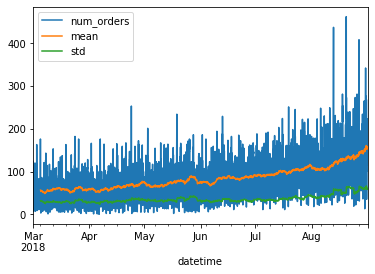

In [ ]:
df['mean'] = df['num_orders'].rolling(100).mean()
df['std'] = df['num_orders'].rolling(100).std()
df.plot() 

Ряд не стационарен - мат. ожидание и дисперсия не являются константами. Однако, я думаю, что не стационарность этого ряда не ялвяется критической, ряд можно описать линенией, а волотильность мат. ожидания и дисперсии не является критическими. Разности временного ряда доблять ненужно.

The series is not stationary - mat. expectation and variance are not constants. However, I think that the non-stationarity of this series is not critical, the series can be described by a line, but the volatility is a mat. expectations and variance are not critical. It is unnecessary to add the differences of the time series.

Удалим столбцы со средним и стандартным отклонением - они нам пока не нужны.

Let's remove the columns with the mean and standard deviation - we don't need them yet.

In [ ]:
df.drop(['mean', 'std'], axis=1, inplace=True)

Посмотрим на крайние наблюдения.

Let's look at extreme observations.

In [ ]:
print('Самое раннее наблюдение', df.index.min())
print('Минимальное наблюдение', df.num_orders.min())
print('Самое позднее наблюдение', df.index.max())
print('Максимальное наблюдение наблюдение', df.num_orders.max())

Самое раннее наблюдение 2018-03-01 00:00:00
Минимальное наблюдение 0
Самое позднее наблюдение 2018-08-31 23:00:00
Максимальное наблюдение наблюдение 462


Earliest Observation 2018-03-01 00:00:00

Minimum observation 0

Latest observation 2018-08-31 23:00:00

Maximum surveillance surveillance 462

Итак, у нас данные с марта по август 2018 года. То есть наблюдать ГОДОВУЮ сезонность по этому сету мы не можем.  

So, we have data from March to August 2018. That is, we cannot observe ANNUAL seasonality for this set.

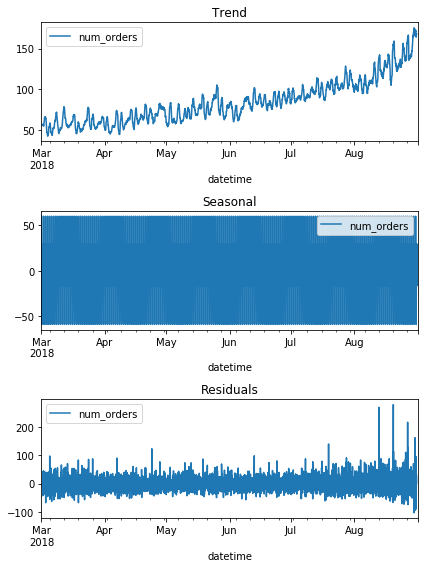

In [ ]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Можно увидеть тренд - количество заказов растет со временем: от марта к августу. 

You can see the trend - the number of orders is growing over time: from March to August.

Посмотрим на сезонность внутри каждого месяца по дням.

Let's look at the seasonality within each month by day.

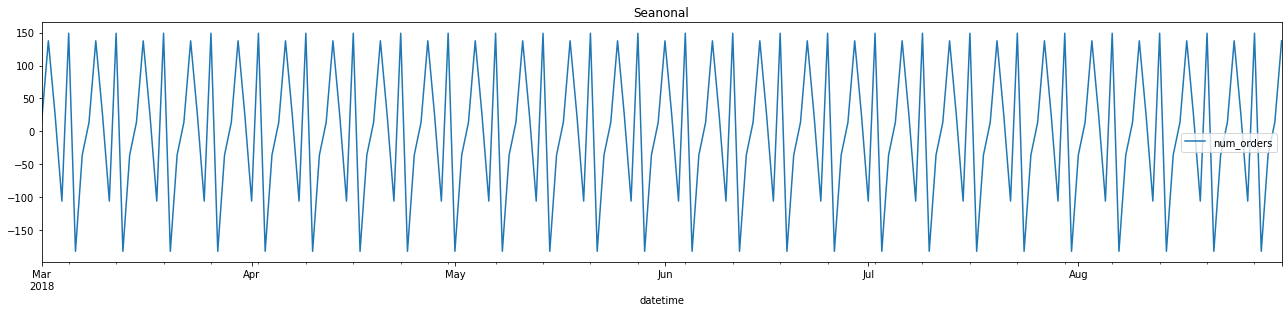

In [ ]:
df_copy = df.copy()
df_copy = df_copy.sort_index()
df_copy = df_copy.resample('1D').sum()
decomposed_copy = seasonal_decompose(df_copy)
plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed_copy.seasonal.plot(ax=plt.gca())
plt.title('Seanonal')
plt.tight_layout()

Выберем один день и посмотрим на график количества заказов внутри него (одноименные дни похожи друг на друга из недели в неделю, как видно из графика выше).

Let's choose one day and look at the graph of the number of orders inside it (the same-named days are similar to each other from week to week, as you can see from the graph above).

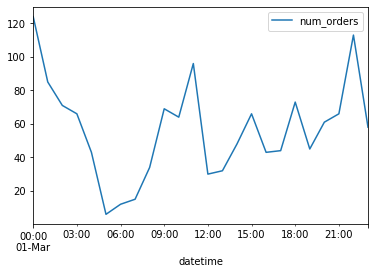

In [ ]:
df['2018-03-01':'2018-03-01'].plot()

Видим, что пиковые загрузки наблюдаются в 00, 11 и 22 часов. С 5 до 7 утра заказов меньше всего.

We see that peak loads are observed at 00, 11 and 22 hours. From 5 to 7 in the morning there are the fewest orders.

На графике можно увидеть, что внутри каждую неделю каждого месяца колебания одинаковые. То есть есть недельная сезонность.

On the graph, you can see that inside every week of every month the fluctuations are the same. That is, there is a weekly seasonality.

Результаты анализа.
- Ряд не стационарен, но не критично.
- Наблюдается восходящий тренд количества заказов со временем.
- Есть недельная и дневная сезонности.

Analysis results.
- The series is not stationary, but not critical.
- There is an upward trend in the number of orders over time.
- There are weekly and daily seasonality.

<a id='Step_3'></a>
# Обучение

# Education

Создадим функцию, которая добавит признаки: день недели и час. Так же функция добавит временные лаги  и скольязящее среднее (количество лагов и интервал усредненния побираются экспеременатально). 

Let's create a function that will add signs: day of the week and hour. The function will also add time lags and a moving average (the number of lags and the averaging interval are selected experimentally).

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour  
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
MSE = make_scorer(mean_squared_error, greater_is_better=False)

Разделим сет на обучение и тест.

Let's divide the set into training and testing.

In [ ]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train_cv = train.copy()

<a id='Step_4'></a>
##  Регрессия.

# Regression.

In [ ]:
# Создадим списки в которые будем сохранять результаты подбора парметров функции make_features.
list_max_lag = []
list_rolling_mean_size = []
list_parameters = []
list_results = []
# Создадим цикл для подбора вышеупомянутых параметров.
for i in (1,2,3,4,5,10,20):
    for j in (1,20,30,50,75,100):        
        # Создадим новые параметры. 
        make_features(train_cv, i, j)
        # Удалим строки с пропущенными значенниями.
        train_cv = train_cv.dropna()
        # Получим признаки и целевую перменную.
        X_train = train_cv.drop('num_orders', axis=1)
        y_train = train_cv['num_orders']
        # Сделаем модель для таймсериес сплит.
        model = Ridge()
        parameters = {'fit_intercept':(True, False), 'alpha':(1, 10, 50, 100)}
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring=MSE)
        # Обучим модель и проверим параметры.
        gsearch.fit(X_train, y_train)
        # Запишем результаты работы цикла и таймсериес сплит.
        list_max_lag.append(i)
        list_rolling_mean_size.append(j)
        list_parameters.append(gsearch.best_params_)
        list_results.append(gsearch.best_score_)
        # Создадим таблицу с результатами.
        regression_results = pd.DataFrame({'max_lag':list_max_lag, 'rolling_mean_size':list_rolling_mean_size, 
                                                   'parameters': list_parameters, 'results':list_results})
        # Обнулим тренировочный фрейм.
        train_cv = train.copy()
# Выведем рузультаты на экран.
regression_results.sort_values('results',ascending=False).head(5)

,max_lag,rolling_mean_size,parameters,results
40,20,75,"{'alpha': 1, 'fit_intercept': True}",-992.620924
39,20,50,"{'alpha': 1, 'fit_intercept': True}",-996.403223
41,20,100,"{'alpha': 1, 'fit_intercept': True}",-999.513611
38,20,30,"{'alpha': 100, 'fit_intercept': False}",-1010.881899
34,10,75,"{'alpha': 100, 'fit_intercept': False}",-1080.819622


<a id='Step_5'></a>
##  Случайный лес.

## Random forest.

In [ ]:
# Создадим списки в которые будем сохранять результаты подбора парметров функции make_features.
list_max_lag = []
list_rolling_mean_size = []
list_parameters = []
list_results = []
# Создадим цикл для подбора вышеупомянутых параметров.
for i in (1,2,3,4,5,10,20):
    for j in (1,20,30,50,75,100):        
        # Создадим новые параметры. 
        make_features(train_cv, i, j)
        # Удалим строки с пропущенными значенниями.
        train_cv = train_cv.dropna()
        # Получим признаки и целевую перменную.
        X_train = train_cv.drop('num_orders', axis=1)
        y_train = train_cv['num_orders']
        # Сделаем модель для таймсериес сплит.
        model = RandomForestRegressor()
        parameters = {'max_depth':(1,5,10,19,20), 'n_estimators':(1, 20,100)}
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring=MSE)
        # Обучим модель и проверим параметры.
        gsearch.fit(X_train, y_train)
        # Запишем результаты работы цикла и таймсериес сплит.
        list_max_lag.append(i)
        list_rolling_mean_size.append(j)
        list_parameters.append(gsearch.best_params_)
        list_results.append(gsearch.best_score_)
        # Создадим таблицу с результатами.
        forest_results = pd.DataFrame({'max_lag':list_max_lag, 'rolling_mean_size':list_rolling_mean_size, 
                                                   'parameters': list_parameters, 'results':list_results})
        # Обнулим тренировочный фрейм.
        train_cv = train.copy()
# Выведем рузультаты на экран.
forest_results.sort_values('results', ascending=False).head(5)

,max_lag,rolling_mean_size,parameters,results
33,10,50,"{'max_depth': 20, 'n_estimators': 100}",-750.681251
34,10,75,"{'max_depth': 19, 'n_estimators': 100}",-751.271824
28,5,75,"{'max_depth': 19, 'n_estimators': 100}",-757.725243
35,10,100,"{'max_depth': 19, 'n_estimators': 100}",-761.059595
29,5,100,"{'max_depth': 19, 'n_estimators': 100}",-767.303964


<a id='Step_6'></a>
##  Градиентный бустинг.

## Gradient boosting.

In [ ]:
# Создадим списки в которые будем сохранять результаты подбора парметров функции make_features.
list_max_lag = []
list_rolling_mean_size = []
list_parameters = []
list_results = []
# Создадим цикл для подбора вышеупомянутых параметров.
for i in (1,2,3,4,5,10,20):
    for j in (1,20,30,50,75,100):        
        # Создадим новые параметры. 
        make_features(train_cv, i, j)
        # Удалим строки с пропущенными значенниями.
        train_cv = train_cv.dropna()
        # Получим признаки и целевую перменную.
        X_train = train_cv.drop('num_orders', axis=1)
        y_train = train_cv['num_orders']
        # Сделаем модель для таймсериес сплит.
        model = LGBMRegressor()
        parameters = {'learning_rate':(0.1, 0.3, 0.5, 0.7), 'reg_lambda':(0, 5, 50)}
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, scoring=MSE)
        # Обучим модель и проверим параметры.
        gsearch.fit(X_train, y_train)
        # Запишем результаты работы цикла и таймсериес сплит.
        list_max_lag.append(i)
        list_rolling_mean_size.append(j)
        list_parameters.append(gsearch.best_params_)
        list_results.append(gsearch.best_score_)
        # Создадим таблицу с результатами.
        lgbm_results = pd.DataFrame({'max_lag':list_max_lag, 'rolling_mean_size':list_rolling_mean_size, 
                                                   'parameters': list_parameters, 'results':list_results})
        # Обнулим тренировочный фрейм.
        train_cv = train.copy()
# Выведем рузультаты на экран.
lgbm_results.sort_values('results', ascending=False).head(5)

,max_lag,rolling_mean_size,parameters,results
41,20,100,"{'learning_rate': 0.1, 'reg_lambda': 5}",-772.327469
36,20,1,"{'learning_rate': 0.1, 'reg_lambda': 5}",-772.821629
37,20,20,"{'learning_rate': 0.1, 'reg_lambda': 5}",-778.815123
40,20,75,"{'learning_rate': 0.1, 'reg_lambda': 0}",-778.984964
38,20,30,"{'learning_rate': 0.1, 'reg_lambda': 5}",-781.729205


<a id='Step_7'></a>
# Тестирование

# Testing

Будем использовать LGMB с параметрами {'learning_rate': 0.1, 'reg_lambda': 0} и	добавим признани через функцию make_features с парметрами max_lag=10 и rolling_mean_size=20

We will use LGMB with parameters {'learning_rate': 0.1, 'reg_lambda': 0} and add recognition through the make_features function with parameters max_lag=10 and rolling_mean_size=20

In [ ]:
make_features(df, 10, 20)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']
model = LGBMRegressor(learning_rate = 0.1, reg_lambda = 0)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print('RMSE', mean_squared_error(prediction, y_test) ** 0.5)

RMSE 43.522650259264715


Общий вывод.
- Нами были подгтовленны данные: сортировка и ресемплирование.
- Пронализирован времнной ряд: он не стационарный (не критичично), наблюдается недельная сезонность, наблюдается восходящий тренд.
- Обучены модели на кросс-валидации: регрессия, случайный лес, градиентный бустинг.
- Тестирование модели LGMB: получены подоходязие результаты - RMSE меньше 48.

General conclusion.
- We have prepared data: sorting and resampling.
- The time series has been analyzed: it is not stationary (not critical), there is a weekly seasonality, an uptrend is observed.
- Trained models for cross-validation: regression, random forest, gradient boosting.
- Testing the LGMB model: Appropriate results obtained - RMSE less than 48.